In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from astropy import units as u
from scipy.stats import norm
from specutils.spectra import Spectrum1D
from pytodcor.xcor.todcor import todcor
from pytodcor.lib.spectrum import Spectrum

This notebook captures unit tests for the `todcor` function. The same tests are defined in a unittest .py file, but the notebook allows for further interactivity and visualization for debugging purposes when needed.

Case Parameters:
  - Is Observed X-Axis Identical To Templates' X-Axis? TRUE

  - Is There No Shift Between Observed Feature and Template Feature? TRUE

  - Is There No Difference In Shape Of Observed Feature Height Compared To Template? TRUE

  - Is There No Difference in Shape Of Observed Feature Width Compared To Template? TRUE

  - Is The Scaling Ratio Between Model Templates Fixed? TRUE


# Case #1:

Observed and Template X-Axes are identical so no special considerations for gaps between template and observed wavelength coverage. The features in the observed spectrum and templates are at the same x-axis location, so the algorithm should find no need to apply a shift to match. The height and width of the observed spectral features are identical to the templates, so the algorithm should find exactly two peaks when shifting both models (4 total peaks.) The scaling ratio between the two models is fixed to 1.0.

In [2]:
# Generate the Gaussians to use.
gauss_1_peak = 5380.
gauss_2_peak = 5420.
xvals = np.linspace(5300., 5500., 1000)
g1_y = norm.pdf(xvals, gauss_1_peak, 4.)
g2_y = norm.pdf(xvals, gauss_2_peak, 4.)

obs_y = g1_y + g2_y
mod1_y = g1_y
mod2_y = g2_y

In [3]:
# Identify how many data points separate the two peaks. This is used later when checking results.
n_pix_apart = len(np.where((xvals >= gauss_1_peak) & (xvals <= gauss_2_peak))[0])

In [4]:
# Create Spectrum objects out of the simulated datasets.
obs_spec1d = Spectrum1D(flux=obs_y*u.dimensionless_unscaled,
                           spectral_axis=xvals*u.angstrom)
obs_spec = Spectrum(name="Case_01_Obs", air_or_vac="vacuum")
obs_spec.add_spec_part(obs_spec1d)

mod1_spec1d = Spectrum1D(flux=mod1_y*u.dimensionless_unscaled,
                           spectral_axis=xvals*u.angstrom)
mod1_spec = Spectrum(name="Case_01_Mod1", air_or_vac="vacuum")
mod1_spec.add_spec_part(mod1_spec1d)

mod2_spec1d = Spectrum1D(flux=mod2_y*u.dimensionless_unscaled,
                           spectral_axis=xvals*u.angstrom)
mod2_spec = Spectrum(name="Case_01_Mod2", air_or_vac="vacuum")
mod2_spec.add_spec_part(mod2_spec1d)

        Use Spectrum instead. [warnings]
        Use Spectrum instead. [warnings]
        Use Spectrum instead. [warnings]


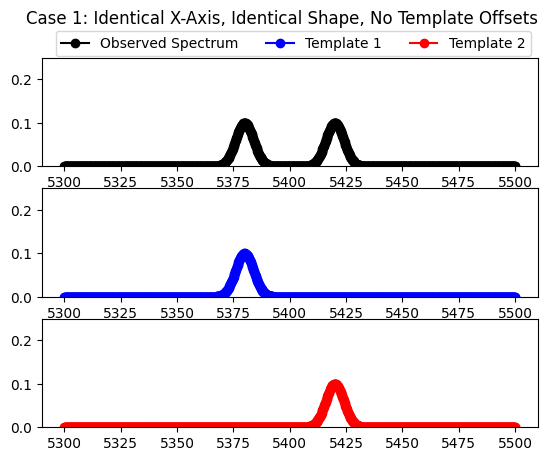

In [5]:
# Visualize the spectrum and templates.
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.set_ylim([0., 0.25])
ax2.set_ylim([0., 0.25])
ax3.set_ylim([0., 0.25])
ax1.plot(obs_spec.parts[0].spectral_axis, obs_spec.parts[0].flux, '-ko', label="Observed Spectrum")
ax2.plot(mod1_spec.parts[0].spectral_axis, mod1_spec.parts[0].flux, '-bo', label="Template 1")
ax3.plot(mod2_spec.parts[0].spectral_axis, mod2_spec.parts[0].flux, '-ro', label="Template 2")
fig.suptitle("Case 1: Identical X-Axis, Identical Shape, No Template Offsets")
fig.legend(ncols=3, bbox_to_anchor=[0.9, 0.95])
plt.show()

Resampling observed spectrum and first template to a common log-lambda wavelength scale...
...total time taken = 0.0741130000000001 seconds.
[0.2002002 0.2002002 0.2002002 0.2002002 0.2002002 0.2002002 0.2002002
 0.2002002 0.2002002 0.2002002 0.2002002 0.2002002 0.2002002 0.2002002
 0.2002002 0.2002002 0.2002002 0.2002002 0.2002002 0.2002002 0.2002002
 0.2002002 0.2002002 0.2002002 0.2002002 0.2002002 0.2002002 0.2002002
 0.2002002 0.2002002 0.2002002 0.2002002 0.2002002 0.2002002 0.2002002
 0.2002002 0.2002002 0.2002002 0.2002002] Angstrom
[0.19292722 0.19293424 0.19294126 0.19294828 0.19295531 0.19296233
 0.19296936 0.19297638 0.19298341 0.19299043 0.19299746 0.19300448
 0.19301151 0.19301853 0.19302556 0.19303258 0.19303961 0.19304664
 0.19305367 0.19306069 0.19306772 0.19307475 0.19308178 0.1930888
 0.19309583 0.19310286 0.19310989 0.19311692 0.19312395 0.19313098
 0.19313801 0.19314504 0.19315207 0.1931591  0.19316613 0.19317317
 0.1931802  0.19318723 0.19319426] Angstrom


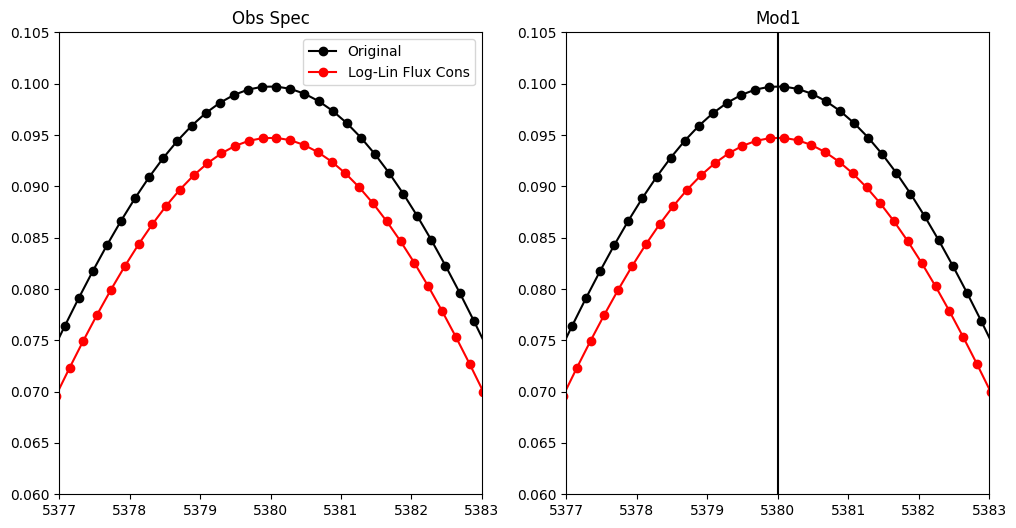

Resampling observed spectrum and second template to a common log-lambda wavelength scale...
...total time taken = 0.039726999999999624 seconds.
Calculating cross-correlations...


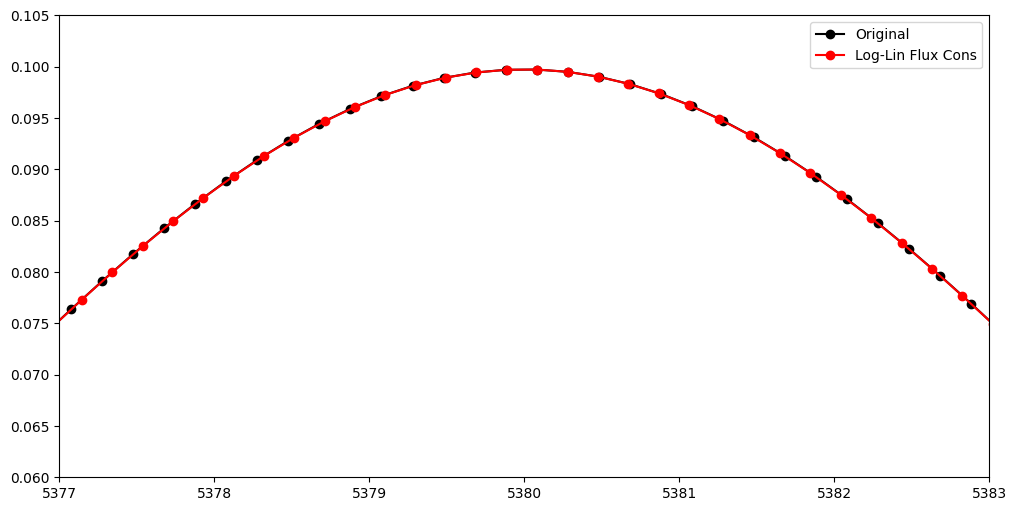

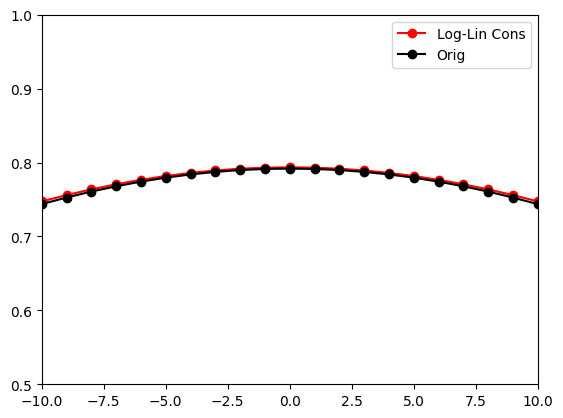

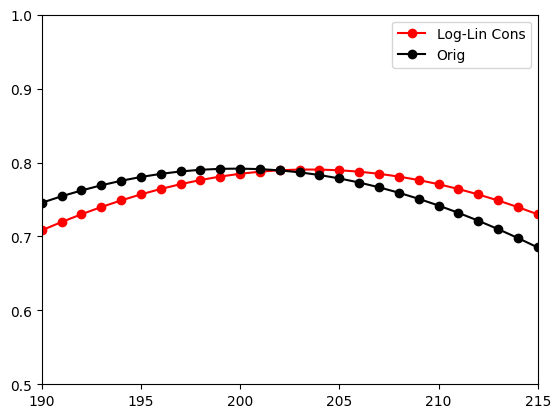

Max value at lag (no resampling) = 0
Max value at lag (flux cons. resampling) = 0
Max value at lag (right hand side, no resampling) = 200
Max value at lag (right hand side, flux cons. resampling) = 203


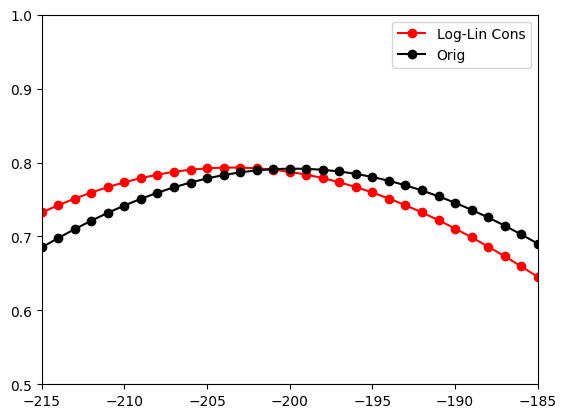

...total time taken = 0.10219099999999992 seconds.
Calculating TODCOR values and populating the two-dimensional surface...
...total time taken = 24.219728 seconds.


In [6]:
# Compute the TODCOR result.
todcor_pixshifts, vel_per_pix, todcor_vals, todcor_alphas = todcor(obs_spec.parts[0], mod1_spec.parts[0],
                                                      mod2_spec.parts[0], 400, fixed_alpha=1.,
                                                      vel_range=[-500., 500.])

In [7]:
# Plot the TODCOR values as a projection across the two template shifts.
%matplotlib widget
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(todcor_pixshifts, todcor_pixshifts, indexing='ij')
Z = todcor_vals
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel("Primary Template Shift")
ax.set_ylabel("Secondary Template Shift")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Plot slices along a specified shift of one of the templates.
x_fix_shift_1 = 0
x_fix_shift_2 = n_pix_apart
y_fix_shift_1 = 0
y_fix_shift_2 = -1*n_pix_apart

where_x1 = np.where(todcor_pixshifts == x_fix_shift_1)[0][0]
where_x2 = np.where(todcor_pixshifts == x_fix_shift_2)[0][0]

where_y1 = np.where(todcor_pixshifts == y_fix_shift_1)[0][0]
where_y2 = np.where(todcor_pixshifts == y_fix_shift_2)[0][0]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(6, 12))
ax1.plot(todcor_pixshifts, todcor_vals[where_x1, :], '-ko')
ax1.set_title("Pri. Shift = 0")
ax2.plot(todcor_pixshifts, todcor_vals[where_x2, :], '-ko')
ax2.set_title("Pri. Shift = 200")
ax3.plot(todcor_pixshifts, todcor_vals[:, where_y1], '-ko')
ax3.set_title("Sec. Shift = 0")
ax4.plot(todcor_pixshifts, todcor_vals[:, where_y2], '-ko')
ax4.set_title("Sec. Shift = -200")
fig.tight_layout()
plt.show()

RuntimeError: 'widget' is not a recognised GUI loop or backend name